In [283]:
import matplotlib.pyplot as plt
from scipy import optimize 
import numpy as np
import seaborn as sns
import glob, re, os

plt.clf()

# _______ define all variables for plotting and importing data ________

date = "181120"          # Date prefix on the filenames 
sample = "BLG_on_HBN"     # Sample string used in the filenames 
current = "3nA"          # Approx. current setpoint of the scans
lock_in = "5mV"          # Lock-in modulation amplitude 

maxbias = 500           # Maximum bias voltage applied 
minbias = -500           # Minimum bias voltage applied

maxgate = 20             # Max. gate voltage 
mingate = 0            # Min. gate voltage 
gatestep = 1             # Look for gate voltage files beginning with mingate and going up in steps of gatestep

dir_name = "/Users/zkrebs/brarlab/data/blg_sweeps/hBN/181120/"   # Path for folder containing datafiles 
os.chdir(dir_name)

<Figure size 432x288 with 0 Axes>

In [284]:
def getFileName(gateVoltage):
    # Gather list of .dat files that contain the right date and sample strings 
    spectrum_files = [ f for f in glob.glob("*.dat") if date in f and sample in f ] 
    for file in spectrum_files:   
        result = re.search("^.*_(-?\d*)V", file)    # Get the gate voltage in filename 
        try:
            gateVal = int(result.group(1)) 
        except:
            continue 
        if gateVal == gateVoltage: # If we found the right one, return it 
            return file 
    return None 

In [372]:
def double(p,x):
    a = p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[1])**2/(2*p[2]**2)) + p[3]
    b = p[4]/(p[6]*np.sqrt(2*np.pi))*np.exp(-(x-p[5])**2/(2*p[6]**2)) + p[7]
    return (a + b)
def residual(p,x,y,):
    return (double(p,x)-y)

In [417]:
gatebias = np.arange(mingate, maxgate + gatestep, gatestep)  # Generate list of gate voltages that we want to include
gate_intervals = []                                          # To account for uneven gate intervals between data points (more later...)
last_gate = mingate 

leftgapdata = []
rightgapdata = []

for i in range(0, int((maxgate - mingate)/gatestep) + 1):
    curr_gate = gatebias[i]
    datafile = getFileName(gatebias[i])
    if datafile is None:
        continue
    
    dIdV_f = np.genfromtxt( datafile, dtype=float, comments="#", usecols=(3), skip_header=19) # Extract Demod1X signal (forward direction)
    #dIdV_b = np.genfromtxt( datafile, dtype=float, comments="#", usecols=(7), skip_header=19) # Backward direction   
    #dIdV_avg = (dIdV_f + dIdV_b)/2
    I_f = np.genfromtxt( datafile, dtype=float, comments="#", usecols=(1), skip_header=19)
    #I_b = np.genfromtxt( datafile, dtype=float, comments="#", usecols=(5), skip_header=19)
    #I_avg = (I_f+I_b)/2
    
    V = np.genfromtxt( datafile, dtype=float, comments="#", usecols=(2), skip_header=19)
    I = I_f
    dIdV = dIdV_f
    dIdVnorm = dIdV/(I/V)
    
    #l = 135
    #r=170
    
    #dIdV_left = dIdV[:l]
    #dIdV_right = dIdV[r:]
    #dIdV = np.concatenate((dIdV_left, dIdV_right), axis=0)

    #dIdVnorm_left = dIdVnorm[:l]
    #dIdVnorm_right = dIdVnorm[r:]
    #dIdVnorm_inelastic = np.concatenate((dIdVnorm_left, dIdVnorm_right), axis=0)
     
    leftwindowdIdV  = dIdV[122:135]
    rightwindowdIdV = dIdV[]
    gapdata.append(windowdIdV)

windowV = V[122:135]*1000

   

1.8957712663933266e-24
1
[ 1.48929282e-10 -7.88008974e+01  8.15018752e+00  5.05696561e-11
  4.59351705e-11 -6.00121234e+01  3.63527060e+00 -3.56282706e-11]


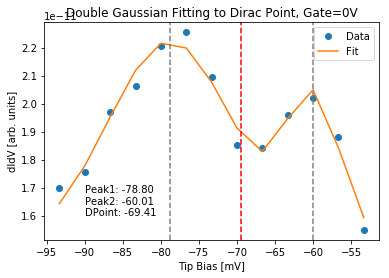

In [418]:
gate = 0
fitdata = gapdata[gate]
p1 = [3e-11,-80,5,0,2e-11,-60,3,0]
pf1, cov1, info1, mesg1, success1 = optimize.leastsq(residual, p1, args=(windowV[:], fitdata[:]), full_output=1)
chisq1 = sum(info1["fvec"]*info1["fvec"])
#pferr1 = [np.sqrt(cov1[i,i]) for i in range(len(pf1))]
#print(pferr1)
print(chisq1)
print(success1)
print(pf1)


peakdiff = np.abs(pf1[1] - pf1[5])
center = pf1[1] + (peakdiff/2)
infotext = "Peak1: %.2f\nPeak2: %.2f\nDPoint: %.2f" % (pf1[1],pf1[5],center)


plt.plot(windowV, fitdata, 'o', label='Data')
plt.plot(windowV, double(pf1,windowV), label='Fit')
plt.axvline(x=pf1[1], color='gray', linestyle='--')
plt.axvline(x=pf1[5], color='gray', linestyle='--')
plt.axvline(x=center, color='red', linestyle='--')
plt.text(-90, 1.6e-11, infotext)
plt.xlabel("Tip Bias [mV]")
plt.ylabel("dIdV [arb. units]")
plt.title("Double Gaussian Fitting to Dirac Point, Gate=" + str(gate) + "V")
plt.legend()


np.save("leftwindow_fit-dgaussian_params_" + str(gate) + "V.npy", pf1)
plt.savefig("leftwindow_fit-dgaussian_plot_" + str(gate) + "V.png")